## Advanced Lane Finding

Brian Erickson

### Abstract
This project aims to find the position of a car in the lane along with the curvature of the road by using advanced lane line finding techniques.  This is an extension of the earlier lane finding project.  My work for that project is at https://github.com/berickson/CarND-LaneLines-P1 and you can view the notebook at http://nbviewer.jupyter.org/github/berickson/CarND-LaneLines-P1/blob/master/P1.ipynb.  This is all implemented as part of the Udacity Self Driving Car Nanodegree.


rubric for this project is at https://review.udacity.com/#!/rubrics/571/view

#### Imports and Helper Functions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython import display
import glob
import pickle
import ipywidgets
import math
%matplotlib inline

In [2]:
def display_images(image_paths, columns=1,width=800,title=None,headings=None):
    '''
    displays table of images given by list of image_paths in the Jupyter notebook
    
    Parameters
    ----------
    image_paths : list of paths to image files
    columns : number of colums to display
    width : total number of pixels for entire table
    title : optional title to display
    headings : optional list of headings for columns
    '''
    column = 0
    html = ''
    if title is not None:
        html = "<b>{0}</b>".format(title)
    html += "<table><tr>"
    if headings is not None:
        for heading in headings:
            html+="<td><b>{0}</b></td>".format(heading)
        html += "</tr><tr>"
    for image_path in image_paths:
        column += 1
        if column > columns:
            column = 1
            html += "</tr><tr>"
        html += "<td>"
        html += "<img width={size} height={size} src='{0}?{r}'>".format(image_path,size=width//columns,r=np.random.randint(1000000))
        html += "<a href={0}?{r} target='_blank'>{0}</a>".format(image_path,r=np.random.randint(1000000))
        html += "</td>"
    
    html += "</tr></table>"
    display.display(display.HTML(html))

def display_images_side_by_side(left_images,right_images,width=800,title=None,headings=None):
    '''
    displays two lists of images side by side
    
    Parameters
    ----------
    image_paths : list of paths to image files
    columns : number of colums to display
    width : total number of pixels for entire table
    title : optional title to display
    headings : optional list of headings for columns
    '''
    lr_images = []
    for left_image,right_image in zip(left_images,right_images):
        lr_images.append(left_image)
        lr_images.append(right_image)
    display_images(lr_images, columns=2, width=width, title=title, headings=headings)

In [3]:
def process_images(input_images, process_function, prefix, output_folder = 'output_images', overwrite=True, plot=False):
    '''
    Helper function that will process images according to a process function
    
    Returns
    -------
    list of processed images
    '''
    output_paths = []
    for input_path in input_images:
        output_path = output_folder+"/"+prefix+os.path.basename(input_path)
        output_paths.append(output_path)
        if overwrite or not os.path.exists(output_path):
            im=plt.imread(input_path)
            im_processed = process_function(im)
            plt.imsave(output_path,im_processed)
        
        if plot:
            fig = plt.figure()
            fig.set_size_inches(w=10,h=5)
            plt.subplot(1,2,1)
            plt.title(input_path)
            plt.imshow(im)
            plt.subplot(1,2,2)
            plt.title(output_path)
            plt.imshow(im_processed,cmap='gray')
    return output_paths

In [4]:
def video_tag(path,width=300,height=240,title=""):
    '''
    generates an HTML fragmentfor displaying the video in path in the notebook
    '''
    return """
    <div style="float:left;padding-left:5px">
    <p>{3}</p>
    <video width="{1}" height="{2}" controls>
      <source src="{0}">
    </video>
    </div>
    """.format(path,width,height,title)

In [5]:
class SideBySideProcessor:
    '''
    Helper class to process videos so that the input and output ar displayed side by side.
    '''
    def __init__ (self, process_callback):
        self.process_callback = process_callback
    def process_image(self, im):
        im_processed = self.process_callback(im)
        im_side_by_side = np.concatenate((im, im_processed), axis=1)
        return im_side_by_side

In [6]:
def process_videos(
    input_videos, 
    process_function, 
    prefix, output_folder = 'output_videos', 
    overwrite=False,
    plot=False,
    side_by_side=False,
    time_range = None
):
    '''
    Applies process_function to a list of videos, generating a corresponding list of output videos
    '''
    output_paths = []
    if side_by_side:
        p = SideBySideProcessor(process_function)
        process_function = p.process_image

    
    for input_path in input_videos:
        output_path = output_folder+"/"+prefix+'_'+os.path.basename(input_path)
        output_paths.append(output_path)
        if overwrite or not os.path.exists(output_path) or os.path.getmtime(output_path) < os.path.getmtime(input_path):
            clip1 = VideoFileClip(input_path)
            if time_range is not None:
                clip1=clip1.subclip(*time_range)
            white_clip = clip1.fl_image(process_function) #NOTE: this function expects color images!!
            %time white_clip.write_videofile(output_path, audio=False)
        
        if plot:
            #html =  video_tag(input_path,title=input_path)
            html = video_tag(output_path,title=output_path)
            display.display(display.HTML(html))
    return output_paths
    

In [7]:
def delete_files(file_list):
    ''' simple helper to delete a list of files'''
    for f in file_list:
        os.remove(f)

##### Global Variables
Input files, color names, and image size

In [8]:
calibration_images = glob.glob('camera_cal/calibration*.jpg')
input_videos = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]
test_images = glob.glob('test_images/*.jpg')

# colors
red = (255,0,0)
green = (0,255,0)
blue = (0,0,255)
cyan = (0,255,255)
magenta = (255,0,255)
white = (255,255,255)

image_width = 1280
image_height = 720

#### Goal: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [9]:
class Camera:
    def __init__(self):
        self.calibrated = False
        
    def calibrate(self, show_annoted = False, show_corrected = False):
        w=9
        h=6
        pattern_size = (w,h)

        # termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        single_object_points = np.zeros((w*h,3), np.float32)
        single_object_points[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2)

        all_object_points = []
        all_image_points = []
        im_shape = None

        for image_path in calibration_images:
            im = plt.imread(image_path)
            im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
            if im_shape == None:
                im_shape = im_gray.shape[::-1]
            found,corners = cv2.findChessboardCorners(im,(9,6),None)
            if found==False: 
                continue
            corners2 = cv2.cornerSubPix(im_gray,corners,(11,11),(-1,-1),criteria)
            all_image_points.append(corners2)
            all_object_points.append(single_object_points)
            if show_annoted:
                plt.figure()
                im_annoted = cv2.drawChessboardCorners(im, pattern_size, corners2, found)
                plt.imshow(im_annoted)

        ret, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(all_object_points, all_image_points, im_shape,None,None)
        self.dist_coefs = dist_coefs
        self.camera_matrix = camera_matrix
        self.calibrated = True
        if show_corrected:
            for image_path in calibration_images:
                im = plt.imread(image_path)   
                plt.figure()
                plt.imshow(cv2.undistort(im,mtx,dst))
    
    def save_calibration(self, path=None):
        if path == None:
            path = 'camera_cal.pickle'
        cal = {}
        cal['dist_coefs'] = self.dist_coefs
        cal['camera_matrix'] = self.camera_matrix
        with open( path, "wb" )  as f:
            pickle.dump(cal,f)

    def load_calibration(self, path=None):
        if path == None:
            path = 'camera_cal.pickle'
        cal = {}
        try:
            with open( path, "rb" )  as f:
                cal = pickle.load(f)
                self.dist_coefs = cal['dist_coefs']
                self.camera_matrix = cal['camera_matrix']
                return True
        except:
            pass
        return False
        
            
    
    def undistort(self, im):
        if not self.calibrated:
            self.calibrate()
        return cv2.undistort(im,self.camera_matrix,self.dist_coefs)


In [10]:
camera = Camera()

In [11]:
if not camera.load_calibration():
    camera.calibrate()
    camera.save_calibration()

In [12]:
undistorted_cal_images = process_images(calibration_images, camera.undistort, prefix="undistorted_",plot = False)

In [13]:
display_images_side_by_side(calibration_images,undistorted_cal_images,headings=['original','undistorted'],title="camera calibration")

original,undistorted
camera_cal/calibration16.jpg,output_images/undistorted_calibration16.jpg
camera_cal/calibration6.jpg,output_images/undistorted_calibration6.jpg
camera_cal/calibration13.jpg,output_images/undistorted_calibration13.jpg
camera_cal/calibration8.jpg,output_images/undistorted_calibration8.jpg
camera_cal/calibration10.jpg,output_images/undistorted_calibration10.jpg
camera_cal/calibration1.jpg,output_images/undistorted_calibration1.jpg
camera_cal/calibration19.jpg,output_images/undistorted_calibration19.jpg
camera_cal/calibration2.jpg,output_images/undistorted_calibration2.jpg
camera_cal/calibration20.jpg,output_images/undistorted_calibration20.jpg
camera_cal/calibration14.jpg,output_images/undistorted_calibration14.jpg


#### Goal: Apply a distortion correction to raw images

In [14]:

undistorted_test_images = process_images(input_images=test_images,process_function=camera.undistort,prefix="undistorted_")
display_images_side_by_side(test_images,undistorted_test_images,headings=['original','undistorted'],title="camera undistort")


original,undistorted
test_images/test2.jpg,output_images/undistorted_test2.jpg
test_images/test5.jpg,output_images/undistorted_test5.jpg
test_images/test6.jpg,output_images/undistorted_test6.jpg
test_images/test3.jpg,output_images/undistorted_test3.jpg
test_images/test1.jpg,output_images/undistorted_test1.jpg
test_images/straight_lines1.jpg,output_images/undistorted_straight_lines1.jpg
test_images/test4.jpg,output_images/undistorted_test4.jpg
test_images/straight_lines2.jpg,output_images/undistorted_straight_lines2.jpg


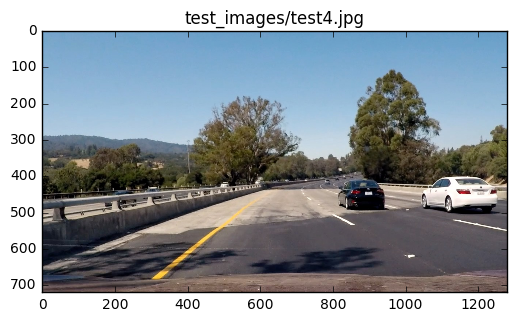

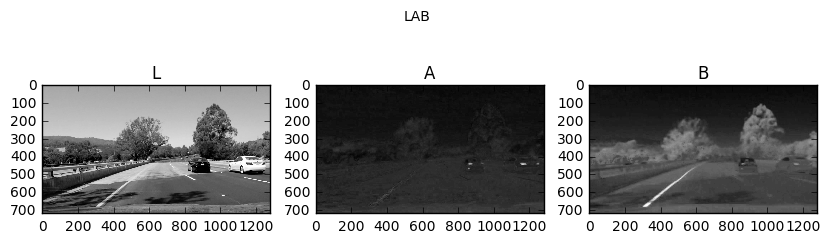

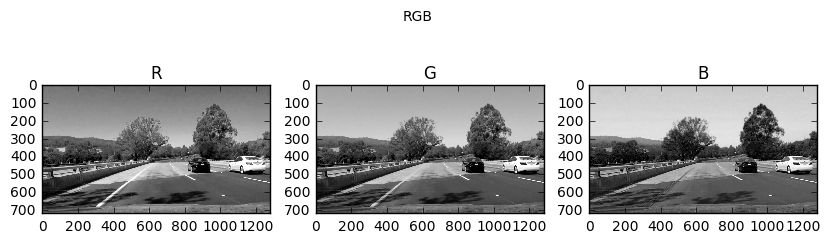

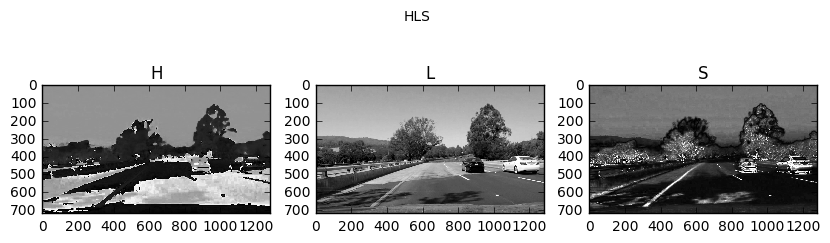

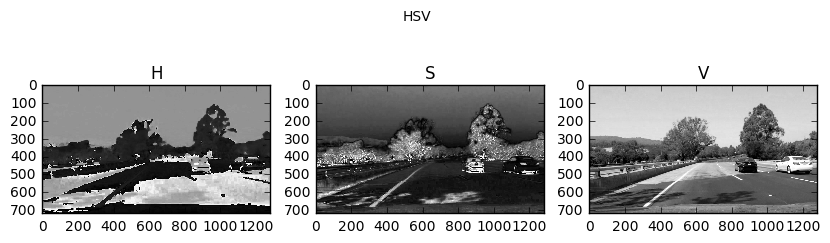

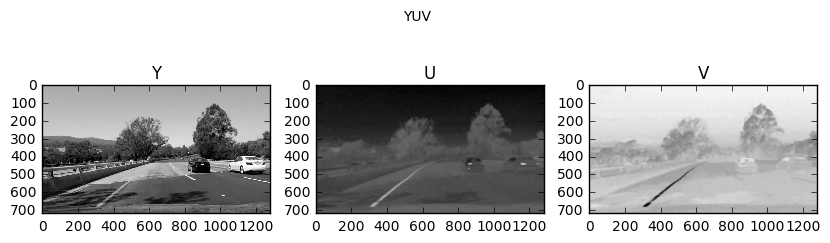

In [15]:
color_spaces = {"HLS": cv2.COLOR_RGB2HLS, "HSV": cv2.COLOR_RGB2HSV, "YUV":cv2.COLOR_RGB2YUV,"LAB":cv2.COLOR_RGB2LAB,"RGB":None}
for f in glob.glob('test_images/test4.jpg'):
    plt.figure()
    plt.title(f)
    im = plt.imread(f)
    plt.imshow(im)
    for space_name,space_conversion in color_spaces.items():
        fig = plt.figure()
        fig.suptitle(space_name)
        fig.set_size_inches(w=10,h=3)
        im2 = cv2.cvtColor(im,space_conversion) if space_conversion else im
        for i,c in enumerate(space_name):
            plt.subplot(1,3,i+1)
            plt.imshow(im2[:,:,i],cmap='gray')
            plt.title(c)

            

In [16]:
def hsl_gray_rgb(im):
    return cv2.cvtColor(cv2.cvtColor(im,cv2.COLOR_RGB2HLS)[:,:,2],cv2.COLOR_GRAY2RGB)

#### Goal: Apply a perspective transform to rectify binary image ("birds-eye view")

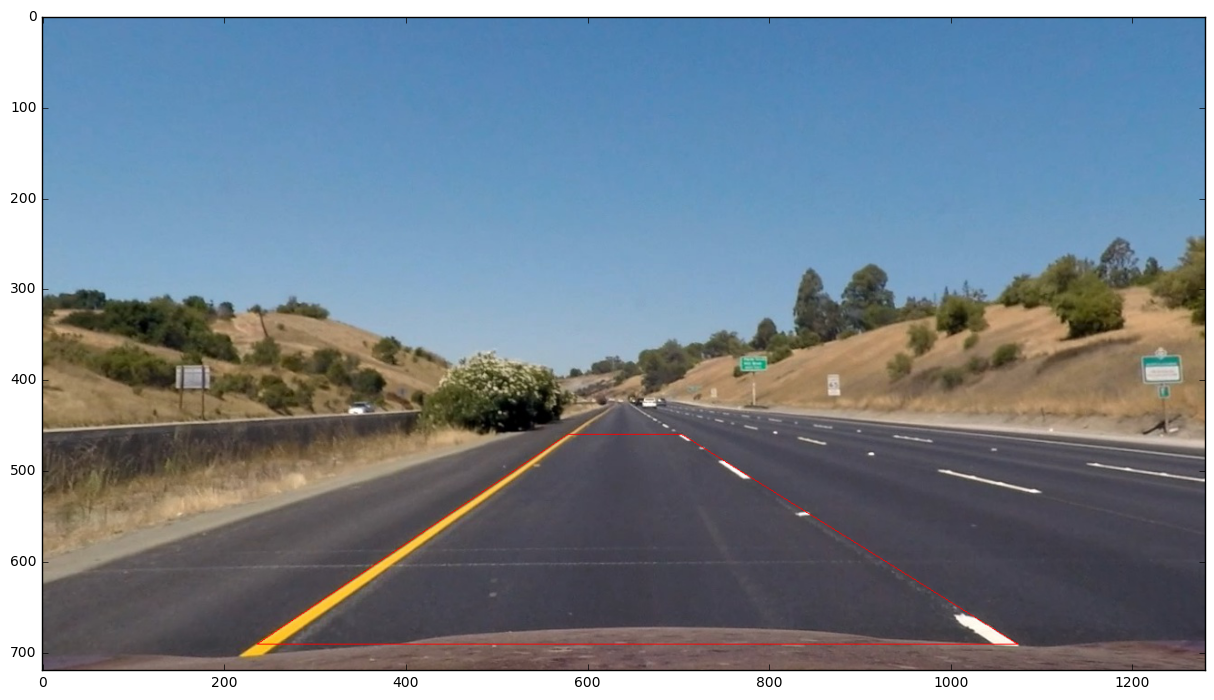

In [17]:

src_poly = [(236,691),(578,460),(703,460),(1073,691)]
im = plt.imread('output_images/undistorted_straight_lines1.jpg')
im = cv2.polylines(im, np.int32([src_poly]), isClosed=True, color=red, thickness=1)
fig = plt.figure()
fig.set_size_inches(w=15,h=10)
plt.imshow(im)
plt.imsave('output_images/transform_src.jpg', im)

In [18]:
def birds_eye(im,flags=cv2.INTER_LINEAR,full_view = False, inverse=False):
    im_shape = (im.shape[1],im.shape[0]) # im_shape (1280, 720)
    # polygons to warp based on eyeballing lanes in Gimp
    dst = None
    src=np.array(src_poly,dtype=np.float32)
    if full_view:
        dst = np.array([(270,710),(270,-600),(1050,-600),(1050,710)],dtype=np.float32)
        dst[:,0] = 0.08805 * dst[:,0] + 540 # constant makes lane width to marker spacing ratio correct
    else:
        dst = np.array([(src[0][0],image_height),(src[0][0],0),(1100,0),(1100,image_height)],dtype=np.float32)
    if inverse:
        src,dst=dst,src
    transform = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(im,transform,im_shape,)

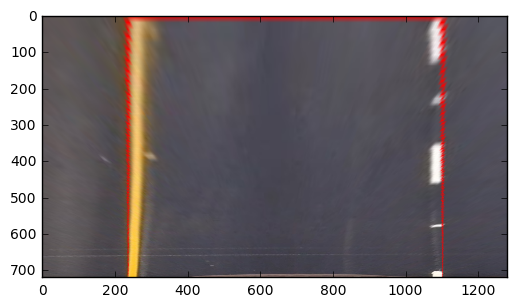

In [19]:
im = birds_eye(im)
plt.imshow(im)
plt.imsave('output_images/birdseye_transform_src.jpg', im)

In [20]:
birds_eye_images = process_images(undistorted_test_images, birds_eye, prefix="birds_eye_");

In [21]:
display_images(glob.glob('output_images/birds_eye_*straight*'))

output_images/birds_eye_undistorted_straight_lines1.jpg
output_images/birds_eye_undistorted_straight_lines2.jpg


In [22]:
display_images(birds_eye_images,columns=4)

output_images/birds_eye_undistorted_test2.jpg,output_images/birds_eye_undistorted_test5.jpg,output_images/birds_eye_undistorted_test6.jpg,output_images/birds_eye_undistorted_test3.jpg
output_images/birds_eye_undistorted_test1.jpg,output_images/birds_eye_undistorted_straight_lines1.jpg,output_images/birds_eye_undistorted_test4.jpg,output_images/birds_eye_undistorted_straight_lines2.jpg


The Interstate Highway standards for the U.S. Interstate Highway System uses a 12-foot (3.7 m) standard for lane width
http://www.dot.ca.gov/trafficops/camutcd/docs/TMChapter6.pdf p.31

3.66m marking, 11m between, dot between

In [23]:
y_meters_per_pixel = 14.66/(481-106) # based on 14.66 meters between two dots at 481 and 106
x_meters_per_pixel = 3.7/(1091-254)  # based on 3.7 meters between lane pixels at 1091 and 254

In [24]:
def find_lanes_on_birdseye(im):
    '''
    returns the x postion of where the lane line might be based on vertical
    histogram analysis
    '''
    mid_x=im.shape[1]//2
    mid_y = im.shape[0]//2
    h = np.sum(im[mid_y:,:,0],axis=0)
    x1 = np.argmax(h[0:mid_x])
    x2 = np.argmax(h[mid_x:])+mid_x
    return x1,x2

def draw_lanes_on_birdseye(im,x1,x2):
    for x in [x1,x2]:
        cv2.line(im,(x,0),(x,image_height),(0,0,255,100),thickness=3)
    s = "x1: {} x2: {} distance: {}".format(x1,x2,x2-x1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(im,s,(10,100), font, 2,(255,255,255),4,cv2.LINE_AA)
    return im

def find_and_draw_lanes_on_birdseye(im):
    x1,x2=find_lanes_on_birdseye(im)
    im = draw_lanes_on_birdseye(im,x1,x2)
    return im

In [25]:
line_guess_images = process_images(birds_eye_images, find_and_draw_lanes_on_birdseye, prefix='line_guess_')

In [26]:
display_images(line_guess_images,columns=2)

output_images/line_guess_birds_eye_undistorted_test2.jpg,output_images/line_guess_birds_eye_undistorted_test5.jpg
output_images/line_guess_birds_eye_undistorted_test6.jpg,output_images/line_guess_birds_eye_undistorted_test3.jpg
output_images/line_guess_birds_eye_undistorted_test1.jpg,output_images/line_guess_birds_eye_undistorted_straight_lines1.jpg
output_images/line_guess_birds_eye_undistorted_test4.jpg,output_images/line_guess_birds_eye_undistorted_straight_lines2.jpg


#### Goal: Use color transforms, gradients, etc., to create a thresholded binary image

I chose to perform the thresholding on the birds-eye image.  This allows the algorighm to ignore most of the irrelevent scenery and enables using a percentile function to estimate light/dark in way that is relative to the road coloration.

In [27]:
def lane_gray(im):
    '''
    returns a grayscale image where lane lines stand out the most, 
    currently using the R channel from RGB, returns as RGB for display convenience
    '''
    return cv2.cvtColor(im[:,:,0],cv2.COLOR_GRAY2RGB)

In [28]:
gray_birds_images = process_images(birds_eye_images,process_function=lane_gray,prefix='gray_birds_')

In [29]:
display_images(gray_birds_images,columns=2)

output_images/gray_birds_birds_eye_undistorted_test2.jpg,output_images/gray_birds_birds_eye_undistorted_test5.jpg
output_images/gray_birds_birds_eye_undistorted_test6.jpg,output_images/gray_birds_birds_eye_undistorted_test3.jpg
output_images/gray_birds_birds_eye_undistorted_test1.jpg,output_images/gray_birds_birds_eye_undistorted_straight_lines1.jpg
output_images/gray_birds_birds_eye_undistorted_test4.jpg,output_images/gray_birds_birds_eye_undistorted_straight_lines2.jpg


In [30]:
def detect_edges(im,ksize=21):
    '''
    Returns a simple sobel detection`
    '''
    return cv2.Sobel(im,cv2.CV_32F,dx=1,dy=0,ksize=ksize)

In [31]:
def threshold(gray, percent=99, relative = 0.8):
    cutoff = np.percentile(gray,percent) * relative
    _,rv= cv2.threshold(gray, cutoff, 255, cv2.THRESH_BINARY)
    
    return cv2.convertScaleAbs(rv)

In [32]:
threshold_images = process_images(gray_birds_images,process_function=lambda im: threshold(im,relative=1.0),prefix='threshold_')
display_images(threshold_images,columns=2)

output_images/threshold_gray_birds_birds_eye_undistorted_test2.jpg,output_images/threshold_gray_birds_birds_eye_undistorted_test5.jpg
output_images/threshold_gray_birds_birds_eye_undistorted_test6.jpg,output_images/threshold_gray_birds_birds_eye_undistorted_test3.jpg
output_images/threshold_gray_birds_birds_eye_undistorted_test1.jpg,output_images/threshold_gray_birds_birds_eye_undistorted_straight_lines1.jpg
output_images/threshold_gray_birds_birds_eye_undistorted_test4.jpg,output_images/threshold_gray_birds_birds_eye_undistorted_straight_lines2.jpg


In [33]:
def color_edges(im):
    '''
    takes a grayscale birdseye image as input
    
    returns an image with left edges in the red channel and right edges in the green channel
    left/right split is blue channel (blue=right)
    '''
    e = detect_edges(im)
    right = threshold(e)
    left = threshold(-1.0*e)
    both = np.zeros_like(right)
    both[:,:,0] = left[:,:,0]
    both[:,:,1] = right[:,:,0]
    mid_x = both.shape[1]//2
    both[:,mid_x:,2]=both[:,mid_x:,0]+both[:,mid_x:,1] # add blue channel to right hand pixels
    return both


In [34]:
edges_images = process_images(gray_birds_images,process_function=color_edges,prefix='edges_')

In [35]:
display_images(edges_images,columns=2,title='left and right edges detected')

output_images/edges_gray_birds_birds_eye_undistorted_test2.jpg,output_images/edges_gray_birds_birds_eye_undistorted_test5.jpg
output_images/edges_gray_birds_birds_eye_undistorted_test6.jpg,output_images/edges_gray_birds_birds_eye_undistorted_test3.jpg
output_images/edges_gray_birds_birds_eye_undistorted_test1.jpg,output_images/edges_gray_birds_birds_eye_undistorted_straight_lines1.jpg
output_images/edges_gray_birds_birds_eye_undistorted_test4.jpg,output_images/edges_gray_birds_birds_eye_undistorted_straight_lines2.jpg


#### Goal: Detect lane pixels and fit to find the lane boundary

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

def fit_polynomial2(X,Y):
    '''
    returns coefficients,model of 2nd degree polynomial ransac fit
    '''
    X = np.reshape(np.array(X),(len(X),1))
    Y = np.reshape(np.array(Y),(len(Y),1))
    poly = PolynomialFeatures(degree=2)
    X_ = poly.fit_transform(X)
    try:
        model = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False),residual_threshold=5)
        model.fit(X_,Y)
    except ValueError:
        model = linear_model.RANSACRegressor(linear_model.LinearRegression(fit_intercept=False))
        model.fit(X_,Y)
    return (model.estimator_.coef_[0], model)



In [37]:
def get_line_coefs_for_edges(im):
    '''
    returns four arrays of line coefficents (a,b,c) for the four lane line edges in im
    where x = a + b*y + c*y^2
    assumes edges are colored green, red, cyan, magenta from left to right
    '''
    coef_list = []
    world_coef_list = []
    
    left_left = np.logical_and(im[:,:,1]>128,im[:,:,2]<128)
    left_right = np.logical_and(im[:,:,0]>128,im[:,:,2]<128)
    right_left = np.logical_and(im[:,:,1]>128,im[:,:,2]>128)
    right_right = np.logical_and(im[:,:,0]>128,im[:,:,2]>128)
    for im_edge in [left_left,left_right,right_left,right_right]:
        y,x = np.nonzero(im_edge)
        h= im.shape[0]-y
        coefs, model = fit_polynomial2(h,x)
        world_coefs, world_model = fit_polynomial2(y*y_meters_per_pixel,x*x_meters_per_pixel)
        coef_list.append(coefs)
        world_coef_list.append(world_coefs)
    return coef_list, world_coef_list

    

In [38]:
line_colors = [green,red,cyan,magenta]

def draw_edge_lines(im, coefs_list):
    '''
    draws lane lines on an image, one coloer per edge, and fills the center lane portion
    with a solid color.
    
    Parameters
    ----------
    coefs_list : list o 2nd order polynomial fit coefficients, one per line edge, left to right
    '''

    y_values = np.int32(np.linspace(0,image_height))
    x_values_list = []
    for coefs in coefs_list:
        a,b,c=coefs
        x_values = a+b*y_values+c*y_values*y_values
        x_values_list.append(x_values)
    
    h = im.shape[0]
    left = np.array([np.transpose(np.vstack([x_values_list[1], h-y_values]))])
    right = np.array([np.flipud(np.transpose(np.vstack([x_values_list[2], h-y_values])))])
    shape = np.hstack((left, right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(im, np.int_([shape]), blue)

    for x_values, line_color in zip(x_values_list, line_colors):
        pts = np.int32(list(zip(x_values,h-y_values)))
        cv2.polylines(im,[pts],False,color=line_color,thickness=10)

    return im    

In [39]:
def find_and_draw_edge_lines(im):
    '''
    processing function that finds and draws lane edges in a single step
    '''
    coefs_list,_ = get_line_coefs_for_edges(im)
    return draw_edge_lines(im,coefs_list)


In [40]:
edge_draw_images = process_images(edges_images, process_function=find_and_draw_edge_lines, prefix='edge_drawn_')

In [41]:
display_images(edge_draw_images,columns=2)

output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test2.jpg,output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test5.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test6.jpg,output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test3.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test1.jpg,output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_straight_lines1.jpg
output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_test4.jpg,output_images/edge_drawn_edges_gray_birds_birds_eye_undistorted_straight_lines2.jpg


In [42]:
def process_one_image(im):
    im_undistorted = camera.undistort(im)
    im_birds_eye = birds_eye(im_undistorted)
    im_gray = lane_gray(im_birds_eye)
    im_color_edges = color_edges(im_gray)
    coefs_list, _ = get_line_coefs_for_edges(im_color_edges)
    im_overlay = np.zeros_like(im_color_edges)
    draw_edge_lines(im_overlay,coefs_list)
    im_undistorted_edges = birds_eye(im_overlay, inverse=True)
    im_final = cv2.addWeighted(im_undistorted,1.0,im_undistorted_edges,0.5,0)
    
    return im_final
    

In [43]:
class line_edge:
    def __init__(self, color):
        self.is_valid = False
        self.coefs = None
        self.world_coefs = None
        self.color = color
        
    def value_at_y(self,y):
        y=y-image_height
        if self.coefs is None:
            return 0.0
        a,b,c=self.coefs
        return a+b*y+c*y*y
    
    def radius_of_curvature(self,y=0):
        '''
        radius of curvature in world cordinates, y is relative to car, not image
        '''
        a,b,c = self.world_coefs
        image_radius = ((1 + (2*c*y + b)**2)**1.5) / (2*c) # removed np.absolut
        world_radius = image_radius
        return world_radius

In [44]:
def draw_calculated_line(im, coefs, color, thickness):
    a,b,c=coefs
    y_values = np.int32(np.linspace(0,image_height))
    x_values = a+b*y_values+c*y_values*y_values
    pts = np.int32(list(zip(x_values,im.shape[0]-y_values)))
    cv2.polylines(im,[pts],False,color=color,thickness=thickness)

In [45]:
def mask_color_edges(im, line_edges,tolerance=50):
    '''
    removes pixels more distant than tolerance from each line_edge
    '''
    im_out = np.zeros_like(im)
    for line_edge in line_edges:
        c = line_edge.color
        mask1 = cv2.inRange(im,c,c)
        #plt.figure()
        #plt.imshow(mask1)
        #plt.title('mask1')
        mask2 = np.zeros_like(im)
        draw_calculated_line(mask2,line_edge.coefs,thickness=tolerance*2,color=white)
        mask2=(mask2[:,:,0]>0)
        #plt.figure()
        #plt.title('mask2')
        #plt.imshow(mask2)
        mask3 = mask1*mask2
        im_out += cv2.bitwise_or(im,im_out,mask=mask3)
        #plt.figure()
        #plt.imshow(im_out)
    
    return im_out
        
        
    
    

In [46]:
def draw_text(im, text,x=50,y=50):
    dy = 25
    for line in text.split('\n'):
        cv2.putText(im, line, (x, y ), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=green, thickness=2)
        y += dy


In [47]:


class stream_processor:
    def __init__(self,process_limit = None):
        self.line_edges = [line_edge(c) for c in line_colors]
        self.process_limit = process_limit
        self.number_processed = 0
    
    def position_in_lane(self):
        '''
        returns number from 0 to 1 of position in line based
        '''
        if self.line_edges is None:
            return 0.5
        l = self.line_edges[1].value_at_y(image_height)
        r = self.line_edges[2].value_at_y(image_height)
        mid = image_width/2.
        return (mid-l)/(r-l)

    def meters_right_of_center(self):
        l = self.line_edges[1].value_at_y(image_height)
        r = self.line_edges[2].value_at_y(image_height)
        lane_mid = (r+l)/2
        car_mid = image_width/2
        return (car_mid-lane_mid) * x_meters_per_pixel
        
    
    def radius_of_curvature(self):
        return np.mean([edge.radius_of_curvature(0) for edge in self.line_edges if edge.is_valid])
    
    def process_one_image(self, im):
        im_undistorted = camera.undistort(im)
        im_birds_eye = birds_eye(im_undistorted)
        im_gray = lane_gray(im_birds_eye)
        im_color_edges = color_edges(im_gray)
    
        # todo: mask out edges
        if self.number_processed > 0:
            im_color_edges_masked = mask_color_edges(im_color_edges, self.line_edges, tolerance=50)
            #plt.figure()
            #plt.imshow(im_color_edges_masked)
            coefs_list, world_coefs_list = get_line_coefs_for_edges(im_color_edges_masked)
        else:
            coefs_list, world_coefs_list = get_line_coefs_for_edges(im_color_edges)
        # todo: figure out which coefs are valid
        for line_edge,coefs,world_coefs in zip(self.line_edges,coefs_list, world_coefs_list):
            line_edge.coefs = coefs
            line_edge.world_coefs = world_coefs
            line_edge.is_valid = True
        im_overlay = np.zeros_like(im_color_edges)
        draw_edge_lines(im_overlay,coefs_list)
        im_undistorted_edges = birds_eye(im_overlay, inverse=True)
        im_final = cv2.addWeighted(im_undistorted,1.0,im_undistorted_edges,0.5,0)
        
        #annotate the final image
        s = ""
        for edge in self.line_edges:
            s += "x = {:7.1f} {:+3.1f}y {:+8.06f}y^2 \n".format(edge.coefs[0],edge.coefs[1],edge.coefs[2])
        p = self.meters_right_of_center()
        if p > 0:
            s+= "{:.2f} meters right of center\n".format(p)
        else:
            s+= "{:.2f} meters left of center\n".format(-p)
        s += "car position in lane: {:.1f}%\n".format(self.position_in_lane()*100)
        s += "curve radius {:.0f} meters".format(self.radius_of_curvature())
        draw_text(im_final,s)
        
        self.number_processed += 1
        #plt.figure()
        #plt.imshow(im_final)
    
        return im_final
        

#### Goals: 
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.

In [48]:
def process_single(im):
    processor = stream_processor()
    return processor.process_one_image(im)

In [49]:
processed_images = process_images(test_images[:2],process_function=process_single, prefix="processed_")
display_images(processed_images,columns=2)

output_images/processed_test2.jpg,output_images/processed_test5.jpg


In [50]:
processed_images = process_images(test_images,process_function=process_single, prefix="processed_")
display_images(processed_images,columns=2)

output_images/processed_test2.jpg,output_images/processed_test5.jpg
output_images/processed_test6.jpg,output_images/processed_test3.jpg
output_images/processed_test1.jpg,output_images/processed_straight_lines1.jpg
output_images/processed_test4.jpg,output_images/processed_straight_lines2.jpg


# Video processing

In [51]:
processor = stream_processor()
stream_videos = process_videos(
    input_videos[:1],
    process_function = processor.process_one_image, 
    prefix='streamed',
    plot=True);

[MoviePy] >>>> Building video output_videos/streamed_project_video.mp4
[MoviePy] Writing video output_videos/streamed_project_video.mp4


 15%|█▌        | 195/1261 [01:15<07:

limit_output extension: Maximum message size of 10000 exceeded with 10014 characters